<a href="https://colab.research.google.com/github/kevinmcmanus/numpy/blob/main/BasicGaiaQuery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Quick Gaia Query Tutorial

## Set Up Notebook Environment

In [88]:
# no notebook should be without these
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [89]:
!pip install astroquery

In [90]:
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.table import Table
from astropy.units import Quantity
from astroquery.gaia import Gaia

## Basic ADQL Gaia Query



> `SELECT <columnlist> FROM <source> WHERE <conditions>`

We'll build up these three components and put them together to form the query.


### \<columnlist>

In [91]:
# list of columns to be fetched from  gaia_source table
columnlist =  ', '.join([ 'ra','dec','parallax','pmra','pmdec','dr2_radial_velocity',
								'phot_g_mean_mag','phot_bp_mean_mag', 'phot_rp_mean_mag'])
columnlist

'ra, dec, parallax, pmra, pmdec, dr2_radial_velocity, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag'

### \<source>

In [92]:
#simple enough:
source = 'gaiaedr3.gaia_source'

In the specification above, `gaia_source` is the main Gaia table with one record for each source (star). The table contains some 80-odd columns capturing different aspects of each star's observations.

`gaiaedr3` is the schema specifier: there are different `gaia_source` tables for DR1, DR2 and early DR3, and the schema indicates which one we're interested in. Note that from one DR to another, the column names may vary, such that a `gaia_source` query executed against, say DR2 may require modicifations to execute against early DR3.

The schemas are: `gaiadr`, `gaiadr2`, and `gaiaedr3`.


See [Gaia Paper](https://www.aanda.org/articles/aa/full_html/2018/08/aa32843-18/aa32843-18.html#app) Section 2.1 and Appendix B for discussion of these filters.

### \<conditions>

Two sets of conditions:


1.   Cone search parameters
2.   observational filters



In [93]:
# Cone Search
#construct minimal cone search query filter
# ra, dec are center of cone search in degrees
# radius is search radius in degrees

#cone search around Pleiades # data from SIMBAD (not shown)
ra, dec =   (56.75009433, 24.11647057)
radius = 3 #degrees

cone_search =  'CONTAINS(POINT(\'\', ra, dec), '\
  ' CIRCLE(\'\', {ra}, {dec}, {rad})) = 1 '.format(ra= ra, dec=dec, rad=radius)

cone_search

"CONTAINS(POINT('', ra, dec),  CIRCLE('', 56.75009433, 24.11647057, 3)) = 1 "

In [94]:
# build the observational filters for ADQL query:
obs_filters = ' AND '.join( [
  'parallax_over_error > 10',
  'phot_g_mean_flux_over_error>50',
  'phot_rp_mean_flux_over_error>20',
  'phot_bp_mean_flux_over_error>20',
  'phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)',
  'phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)',
  'visibility_periods_used>8',
  'astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))'
])

obs_filters

'parallax_over_error > 10 AND phot_g_mean_flux_over_error>50 AND phot_rp_mean_flux_over_error>20 AND phot_bp_mean_flux_over_error>20 AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) AND visibility_periods_used>8 AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))'

In [95]:
#put the two conditions together
conditions = f'{cone_search} AND {obs_filters}'
conditions

"CONTAINS(POINT('', ra, dec),  CIRCLE('', 56.75009433, 24.11647057, 3)) = 1  AND parallax_over_error > 10 AND phot_g_mean_flux_over_error>50 AND phot_rp_mean_flux_over_error>20 AND phot_bp_mean_flux_over_error>20 AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) AND visibility_periods_used>8 AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))"

## Do the Query

In [96]:
# put the pieces together:
query_str = f'SELECT {columnlist} FROM {source} WHERE {conditions}'
query_str

"SELECT ra, dec, parallax, pmra, pmdec, dr2_radial_velocity, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag FROM gaiaedr3.gaia_source WHERE CONTAINS(POINT('', ra, dec),  CIRCLE('', 56.75009433, 24.11647057, 3)) = 1  AND parallax_over_error > 10 AND phot_g_mean_flux_over_error>50 AND phot_rp_mean_flux_over_error>20 AND phot_bp_mean_flux_over_error>20 AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) AND visibility_periods_used>8 AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))"

In [97]:
job = Gaia.launch_job_async(query=query_str)
result_tbl = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [98]:
len(result_tbl)

33643

In [99]:
#examine first 5 rows
result_tbl[:5]

ra,dec,parallax,pmra,pmdec,dr2_radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
deg,deg,mas,mas / yr,mas / yr,km / s,mag,mag,mag
float64,float64,float64,float64,float64,float32,float32,float32,float32
59.093597323970634,22.048182256575913,1.1062471430011358,-4.986987998578104,2.1942533196100227,--,15.619543,16.128475,14.9501
59.164161564830884,22.099230518469444,0.7660971113883758,2.838934406215542,-7.421585213234893,--,14.968838,15.480868,14.291632
58.83012228061413,21.808890921958568,1.1575519749718737,2.4922656241382204,-4.9855146794984915,--,16.683268,17.456362,15.831133
58.877768074045996,21.855197138139566,0.5127510964850103,6.300667358054282,-6.168095566654964,--,15.588906,16.078121,14.940136
58.94368055746045,21.904952075573952,0.6285604778542172,-1.6752506474625581,-0.06838866227380622,--,14.083352,14.4641,13.524911


## Diagnostics

In [100]:
# intentionally mess up query_str to see what an error looks like
query_str2 = query_str + 'GuaranteedToFail'
job = Gaia.launch_job_async(query=query_str2)


500 Error 500:
null


HTTPError: ignored

Not very informative.  Synchronous queries give better diagnostics enabling one to see syntax errors in the query string, the most common problem.  Use `Gaia.launch_job` instead of `Gaia.launch_job_asynch`.

`launch_job` returns at most 4000 rows.

In [101]:
#use a synchronous query for diagnostics
job = Gaia.launch_job(query=query_str2)

HTTPError: ignored

## Motion Plot

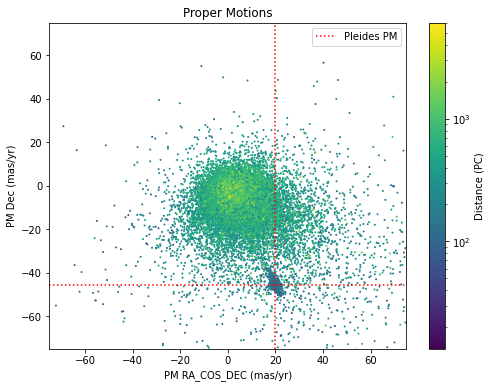

In [102]:
import matplotlib.colors as colors
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()

pcm = ax.scatter(result_tbl['pmra'], result_tbl['pmdec'], s=1, c=1000/result_tbl['parallax'],
                norm=colors.LogNorm() )
ax.set_ylabel('PM Dec (mas/yr)')
ax.set_xlabel('PM RA_COS_DEC (mas/yr)')
ax.set_title('Proper Motions')

#using data from simbad, place cross hairs on Pleiades' PMs.
ax.axvline(19.9999, ls=':', color='red', label='Pleides PM')
ax.axhline(-45.54795337, ls=':', color='red')

ax.legend()

#uncomment zoom in to exclude the outliers
ax.set_xlim(-75, 75)
ax.set_ylim(-75,75)

fig.colorbar(pcm,label='Distance (PC)')

In [103]:
from scipy.stats import kde
def plot_motions(pmra, pmdec, **kwargs):

  ax = kwargs.get('ax')
  title = kwargs.get('title', 'Proper Motions')
  cmap = kwargs.get('cmap', 'viridis')
  nbins = kwargs.get('nbins', 300)
  
  if ax is None:
    fig, yax = plt.subplots()
  else:
    yax = ax
    
  x = np.array(pmra)
  y = np.array(pmdec)
  
  # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
  k = kde.gaussian_kde([x,y])
  xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
  zi = k(np.vstack([xi.flatten(), yi.flatten()]))
  
  pcm = yax.pcolormesh(xi, yi, zi.reshape(xi.shape), norm=colors.LogNorm(),
                       cmap=cmap)
  
  yax.set_title(title)
  yax.set_ylabel('PM Dec (mas/yr)')
  yax.set_xlabel('PM RA (mas/yr)')
  
  if ax is None:
    fig.colorbar(pcm)
  
  return pcm


In [104]:
# just look at stars 75 to 150 pc distance
plx_lo = 1000/150
plx_hi = 1000/75

ra_mask = np.logical_and(result_tbl['pmra']>=-75, result_tbl['pmra']<= 75)
dec_mask = np.logical_and(result_tbl['pmdec']>=-75, result_tbl['pmdec']<= 75)
pm_mask = np.logical_and(ra_mask, dec_mask)
plx_mask = np.logical_and(result_tbl['parallax'] >= plx_lo, result_tbl['parallax']<= plx_hi)


mask = np.logical_and(plx_mask, pm_mask)
pmra = result_tbl['pmra'][mask]
pmdec = result_tbl['pmdec'][mask]

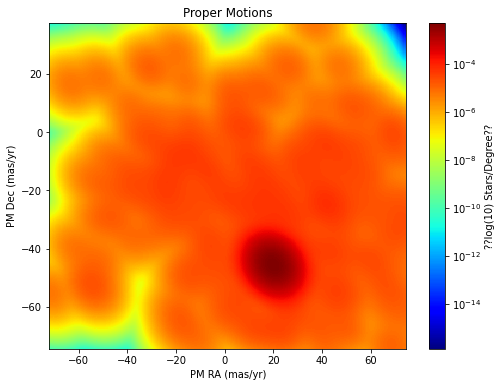

In [105]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()

pcm = plot_motions(pmra, pmdec, ax=ax, cmap='jet')
fig.colorbar(pcm,label='??log(10) Stars/Degree??')

## HR Diagrams

Steps:


1.   calculate distance modulus then absolute magnitude for each star
2.   calculate each star's color
3.   create scatter diagram(s); annotate with labels



Text(0.5, 1.0, 'Color Magnitude Diagram')

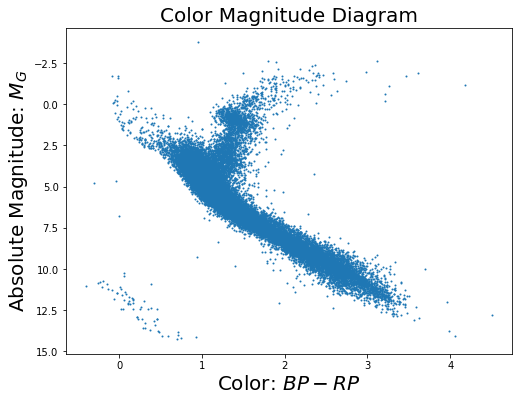

In [106]:
# get absolute magnitude for y axis
dist = 1000/result_tbl['parallax']
distmod = 5*np.log10(dist)-5
M_G = result_tbl['phot_g_mean_mag'] - distmod

# colors
BP_RP = result_tbl['phot_bp_mean_mag'] - result_tbl['phot_rp_mean_mag']

#plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.scatter(BP_RP, M_G, s=1)
ax.invert_yaxis()
ax.set_ylabel('Absolute Magnitude: $M_G$', fontsize=20)
ax.set_xlabel('Color: $BP-RP$', fontsize=20)
ax.set_title('Color Magnitude Diagram', fontsize=20)


Use PM and Parallax masks from above for crude approximation of Pleiades' members

In [107]:
# just look at stars 75 to 150 pc distance
plx_lo = 1000/150
plx_hi = 1000/75

ra_mask = np.logical_and(result_tbl['pmra']>=-75, result_tbl['pmra']<= 75)
dec_mask = np.logical_and(result_tbl['pmdec']>=-75, result_tbl['pmdec']<= 75)
pm_mask = np.logical_and(ra_mask, dec_mask)

plx_mask = np.logical_and(result_tbl['parallax'] >= plx_lo, result_tbl['parallax']<= plx_hi)

mask = np.logical_and(plx_mask, pm_mask)

Text(0.5, 1.0, 'Color Magnitude Diagram')

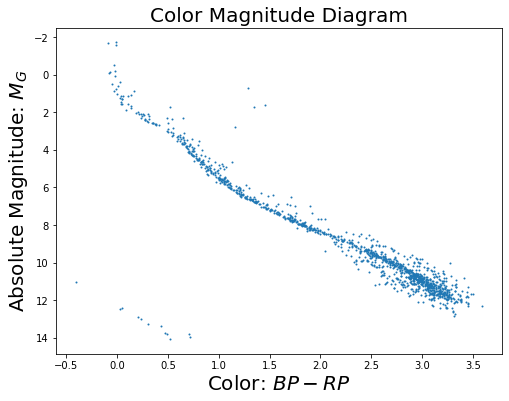

In [108]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()

#create scatter plot using pm and parallax mask from above
ax.scatter(BP_RP[mask], M_G[mask], s=1)

ax.invert_yaxis()
ax.set_ylabel('Absolute Magnitude: $M_G$', fontsize=20)
ax.set_xlabel('Color: $BP-RP$', fontsize=20)
ax.set_title('Color Magnitude Diagram', fontsize=20)

Text(0.5, 1.0, 'Color Magnitude Diagram')

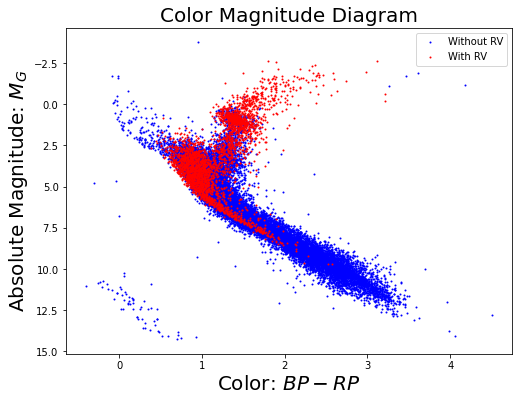

In [109]:
# which ones have radial velocity?
mask2 = np.isfinite(result_tbl['dr2_radial_velocity'])

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()

#plot with and without radial velocity
ax.scatter(BP_RP[~mask2], M_G[~mask2], color='blue', s=1, label='Without RV')
ax.scatter(BP_RP[mask2], M_G[mask2], color='red', s=1, label='With RV')

ax.invert_yaxis()
ax.legend()
ax.set_ylabel('Absolute Magnitude: $M_G$', fontsize=20)
ax.set_xlabel('Color: $BP-RP$', fontsize=20)
ax.set_title('Color Magnitude Diagram', fontsize=20)

